<a href="https://colab.research.google.com/github/Quantum-SMC/quantum_smc/blob/main/quantum_smc_protocol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing requirements

In [ ]:
!pip install qiskit
!pip install qiskit[visualization]


from qiskit import *
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

import numpy as np

import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as

from qiskit import transpile, assemble
from qiskit.visualization import *

from math import sqrt, pi, exp
from qiskit import Aer, execute
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.visualization import plot_bloch_vector
from qiskit.result import marginal_counts

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 83.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 76.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

New SMC protocol to compute symetric Boolean functions

{'110': 224, '101': 264, '000': 256, '011': 256}
0
{'100': 228, '010': 248, '111': 275, '001': 249}
1
{'011': 255, '110': 237, '000': 248, '101': 260}
0
{'000': 234, '101': 241, '011': 281, '110': 244}
0


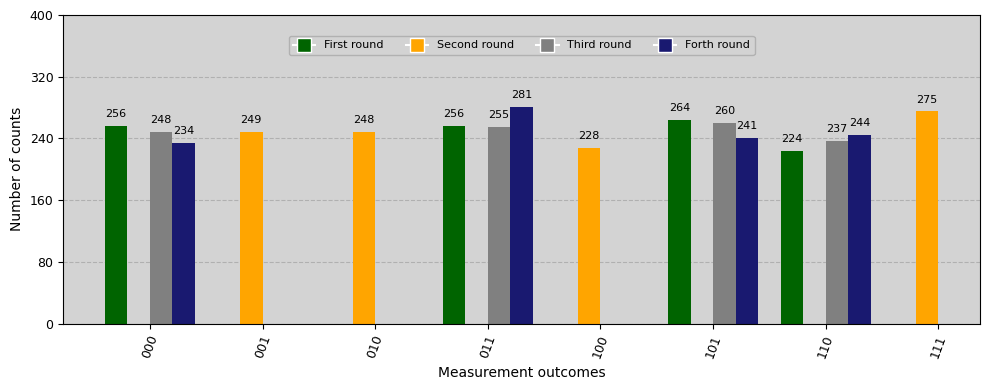

In [ ]:
# version 1 -> Prof. Kshefi's paper
# inputs
a1 = 1
a2 = 1
b1 = 1
b2 = 1
r = [1, 1, 1, 1]  # random bit

# Polynomials to compute equivalence fuction of the paper: Implausible Consequences of Superstrong Nonlocality
# Equivalence(a,b) = 1 + a + b; a = a1 + a2;  b = b1 + b2
P = [
    1^a1^a2^(a1&a2),
    1,
    1^a2,
    1^a1
]
Q = [
    1,
    b1&b2,
    b1,
    b2
]

counts_list = []
colors = ['r', 'g', 'b', 'y']
for i in range(0, 4):
    # Create a quantum circuit
    q = QuantumRegister(3)
    c = ClassicalRegister(3)
    qc = QuantumCircuit(q, c)

    # GHZ state preparation
    qc.barrier()
    qc.h(q[0])
    qc.cx(q[0],q[1])
    qc.cx(q[1],q[2])
    qc.z(q[2])
    qc.x(q[2])
    qc.barrier()

    # Apply rz rotation on the fisrt qubit if r = 1
    if r[i] == 1:
      qc.rz(pi, q[0])

    #qc.rz(pi, q[0]).c_if(r[i], 1)

    # Apply rzdg rotation on the fisrt qubit if P[i] == 1
    if P[i] == 1:
        qc.rz(-pi/2, q[0])
    #qc.rz(-pi/2, q[0]).c_if(P[i], 1)

    # Apply rzdg rotation on the fisrt qubit if Q[i] == 1
    if Q[i] == 1:
        qc.rz(-pi/2, q[1])
    #qc.rz(-pi/2, q[1]).c_if(Q[i], 1)

    # Apply rzdg rotation on the fisrt qubit if (P[i] ^ Q[i]) == 1
    if (P[i]^Q[i]) == 1:
        qc.rz(-pi/2, q[2])
    #qc.rz(-pi/2, q[2]).c_if((P[i]^Q[i]), 1)

    # Apply Hadamard gates for X basis measurement
    qc.barrier()
    qc.h(q[0])
    qc.h(q[1])
    qc.h(q[2])

    # Perform measurement
    qc.measure(q[0], c[0])
    qc.measure(q[1], c[1])
    qc.measure(q[2], c[2])


    #visualization
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=1000)
    result = job.result().get_counts()
    print(result)
    counts_list.append(result)
    #plot_histogram(result).savefig(f'histogram_iteration_{i}.png')

    #ploting bloch sphere for all qubits
#    qc.save_statevector()
#    state = backend.run(qc).result().get_statevector()
#    plot_bloch_multivector(state)

    # Extract the XOR result from classical register
    c_values = [int(bit) for bit in list(result.keys())[0]]
    print(c_values[0] ^ c_values[1] ^ c_values[2])



# Create a new matplotlib figure and Axes object
fig, ax = plt.subplots(figsize=(10, 4))


legends = ['First round', 'Second round', 'Third round', 'Forth round']
colors=['darkgreen', 'orange', 'gray', 'midnightblue']
plot_histogram(counts_list, figsize=(10, 4), color=colors, bar_labels=False, ax=ax)

plt.xlabel("Measurement outcomes", fontsize=10)
plt.ylabel("Number of counts", fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

# Customizing the legend
legend_labels = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=10) for color in colors]
legend = plt.legend(legend_labels, legends, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=len(legends) , fontsize=8)
# Increase the y-axis limit
ax.set_ylim(0, 400)  # Set the desired limit here

# Set the background color
ax.set_facecolor('#D3D3D3')

# Set the background color of the legend
legend.get_frame().set_facecolor('lightgray')
legend.get_frame().set_edgecolor('darkgray')

for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(height, (rect.get_x() + rect.get_width() / 2, height),
                ha='center', va='bottom', fontsize=8,
                xytext=(0, 5), textcoords='offset points')

# Adjust the positioning of the plot within the figure
plt.tight_layout()
plt.savefig('histogram.png')

#my_gate_names = {
#    "displaytext": {
        # gate name : gate text to be displayed
#        "rz": "U"
#    },
#}
#qc.draw('mpl', style=my_gate_names)

{'111': 248, '001': 253, '100': 243, '010': 256}
1
{'101': 259, '011': 244, '110': 245, '000': 252}
0
{'101': 237, '000': 242, '011': 259, '110': 262}
0
{'101': 260, '110': 243, '000': 231, '011': 266}
0


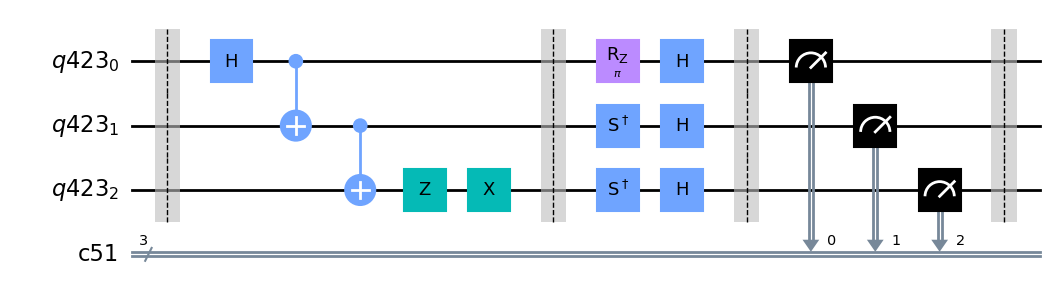

In [ ]:
# version 2
# inputs
a1 = 1
a2 = 1
b1 = 1
b2 = 1
r = [1, 1, 1, 1]  # random bit

# Polynomials to compute equivalence fuction of the paper: Implausible Consequences of Superstrong Nonlocality
# Equivalence(a,b) = 1 + a + b; a = a1 + a2;  b = b1 + b2
P = [
    1^a1^a2^(a1&a2),
    1,
    1^a2,
    1^a1
]
Q = [
    1,
    b1&b2,
    b1,
    b2
]

# Polynomials to compute OR
P = [
    a1&a2,
    a1^(a1 & a2),
    1^a1^a2^(a1 & a2),
    a2^(a1 & a2)
]
Q = [
    1,
    b2,
    b1&b1,
    b1
]

for i in range(0, 4):
    # Create a quantum circuit
    q = QuantumRegister(3)
    c = ClassicalRegister(3)
    qc = QuantumCircuit(q, c)

    # GHZ state preparation
    qc.barrier()
    qc.h(q[0])
    qc.cx(q[0],q[1])
    qc.cx(q[1],q[2])
    qc.z(q[2])
    qc.x(q[2])
    qc.barrier()

    # Apply rz rotation on the fisrt qubit if r = 1
    if r[i] == 1:
      qc.rz(pi, q[0])

    # Measure the first qubit in the σx basis if a = 0, or in the σy basis if a = 1
    if P[i] == 0:
        qc.h(q[0])
    else:
        qc.sdg(q[0])
        qc.h(q[0])

    # Measure the second qubit in the σx basis if b = 0, or in the σy basis if b = 1
    if Q[i] == 0:
        qc.h(q[1])
    else:
        qc.sdg(q[1])
        qc.h(q[1])

    # # Measure the third qubit in the σx basis if c = 0, or in the σy basis if c = 1
    if (P[i] ^ Q[i]) == 0:
        qc.h(q[2])
    else:
        qc.sdg(q[2])
        qc.h(q[2])

    # Perform measurement
    qc.barrier()
    qc.measure(q[0], c[0])
    qc.measure(q[1], c[1])
    qc.measure(q[2], c[2])
    qc.barrier()
    qc.draw('mpl')

    #visualization
    backend = Aer.get_backend('aer_simulator')
    job = execute(qc, backend, shots=1000)
    result = job.result().get_counts()
    plot_histogram (result)
    print(result)

    #ploting bloch sphere for all qubits
#    qc.save_statevector()
#    state = backend.run(qc).result().get_statevector()
#    plot_bloch_multivector(state)

    # Extract the XOR result from classical register
    c_values = [int(bit) for bit in list(result.keys())[0]]
    print(c_values[0] ^ c_values[1] ^ c_values[2])

qc.draw('mpl')

NameError: ignored

Implementation of the symmetric Boolean functions presented in [Secure Multi-Party Computation with a Dishonest Majority via Quantum Means](https://arxiv.org/abs/0906.2297)

In [ ]:
# NOT WORKING

# inputs
a1 = 1
a2 = 1
b1 = 1
b2 = 1
r = [0, 0, 0, 0]  # random bit

# Polynomials to compute equivalence fuction of the paper: Implausible Consequences of Superstrong Nonlocality
# Equivalence(a,b) = 1 + a + b; a = a1 + a2;  b = b1 + b2
P = [
    1^a1^a2^(a1&a2),
    1,
    1^a2,
    1^a1
]
Q = [
    1,
    b1&b2,
    b1,
    b2
]

for i in range (0, 4):
    # Create a quantum circuit
    q = QuantumRegister(3)
    c = ClassicalRegister(3)
    qc = QuantumCircuit(q, c)

    # GHZ state preparation |GHZ⟩ = |y-y-y+>+|y+y+y-> / sqrt(2)
    qc.barrier()
    qc.sdg(q[0])
    qc.h(q[0])
    qc.sdg(q[1])
    qc.h(q[1])
    qc.sdg(q[2])
    qc.h(q[2])
    qc.cx(q[0],q[1])
    qc.cx(q[1],q[2])
    qc.h(q[0])
    qc.x(q[1])


    # Measure the first qubit in the σz basis if a = 0, or in the σx basis if a = 1
    if P[i] == 1:
        qc.h(q[0])

    # Measure the second qubit in the σz basis if b = 0, or in the σx basis if b = 1
    if Q[i] == 1:
        qc.h(q[1])

    # Measure the third qubit in the σz basis if a^b = 0, or in the σx basis if a^b = 1
    if P[i]^Q[i] == 1:
        qc.h(q[2])

    # Perform measurement
    qc.barrier(q)
    qc.measure(q[0], c[0])
    qc.measure(q[1], c[1])
    qc.measure(q[2], c[2])

    #visualization
    backend = Aer.get_backend('aer_simulator')
    job = execute(qc, backend, shots=1000)
    result = job.result().get_counts()
    print(result)

    #ploting bloch sphere for all qubits
    qc.save_statevector()
    state = backend.run(qc).result().get_statevector()
    plot_bloch_multivector(state)

    # Extract the XOR result from classical register
    c_values = [int(bit) for bit in list(result.keys())[0]]
    print(c_values[0] ^ c_values[1] ^ c_values[2])
    #qc.draw()



{'000': 1000}
0
{'100': 227, '001': 269, '000': 272, '101': 232}
1
{'000': 1000}
0
{'000': 1000}
0


Implementation of the SecureNAND presented in [Secure Multi-Party Computation with a Dishonest Majority via Quantum Means](https://arxiv.org/abs/0906.2297)

In [ ]:
# NOT WORKING
# inputs
a = 1
b = 1

# Create a quantum circuit
q = QuantumRegister(3)
c = ClassicalRegister(3)
qc = QuantumCircuit(q, c)

# GHZ state preparation |GHZ⟩ = |y-y-y+>+|y+y+y-> / sqrt(2)
qc.barrier()
qc.sdg(q[0])
qc.h(q[0])
qc.sdg(q[1])
qc.h(q[1])
qc.sdg(q[2])
qc.h(q[2])
qc.cx(q[0],q[1])
qc.cx(q[1],q[2])
qc.h(q[0])
qc.x(q[1])

# Measure the first qubit in the σz basis if a = 0, or in the σx basis if a = 1
if a == 1:
    qc.h(q[0])

# Measure the second qubit in the σz basis if b = 0, or in the σx basis if b = 1
if b == 1:
    qc.h(q[1])

# Measure the third qubit in the σz basis if a^b = 0, or in the σx basis if a^b = 1
if a^b == 1:
    qc.h(q[2])

# Perform measurement
qc.barrier(q)
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])
qc.measure(q[2], c[2])

#visualization
backend = Aer.get_backend('aer_simulator')
job = execute(qc, backend, shots=1000)
result = job.result().get_counts()
print(result)

# Extract the XOR result from classical register
c_values = [int(bit) for bit in list(result.keys())[0]]
print(c_values[0] ^ c_values[1] ^ c_values[2])



{'000': 281, '101': 229, '100': 247, '001': 243}
0


Implementation of the SecureNAND protocol proposed in [Quantum-enhanced
Secure Delegated Classical Computing](https://arxiv.org/abs/1405.4558)

In [ ]:
# inputs
a = 1
b = 1
r = 1

# Create a quantum circuit
q = QuantumRegister(3)
c = ClassicalRegister(3)
qc = QuantumCircuit(q, c)

# GHZ state preparation
qc.barrier()
qc.h(q[0])
qc.cx(q[0],q[1])
qc.cx(q[1],q[2])
qc.z(q[2])
qc.x(q[2])

# Apply rz rotation on the fisrt qubit if r = 1
if r == 1:
  qc.rz(pi, q[0])

# Apply rzdg rotation on the fisrt qubit if P[i] == 1
if a == 1:
    qc.rz(-pi/2, q[0])

# Apply rzdg rotation on the fisrt qubit if Q[i] == 1
if b == 1:
    qc.rz(-pi/2, q[1])

# Apply rzdg rotation on the fisrt qubit if (P[i] ^ Q[i]) == 1
if (a ^ b) == 1:
    qc.rz(-pi/2, q[2])

# Apply Hadamard gates for X basis measurement
qc.h(q[0])
qc.h(q[1])
qc.h(q[2])

# Perform measurement
qc.barrier(q)
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])
qc.measure(q[2], c[2])

#visualization
backend = Aer.get_backend('aer_simulator')
job = execute(qc, backend, shots=1000)
result = job.result().get_counts()
print(result)

#ploting bloch sphere for all qubits
qc.save_statevector()
state = backend.run(qc).result().get_statevector()
plot_bloch_multivector(state)

# Extract the XOR result from classical register
c_values = [int(bit) for bit in list(result.keys())[0]]
print("Nand = ", c_values[0] ^ c_values[1] ^ c_values[2] ^ r)

{'001': 263, '111': 250, '010': 255, '100': 232}
Nand =  0


Implementation of the SecureNAND protocol proposed in [Computational power of correlations](https://arxiv.org/abs/0805.1002)

{'010': 257, '100': 267, '001': 237, '111': 239}
NAND =  1


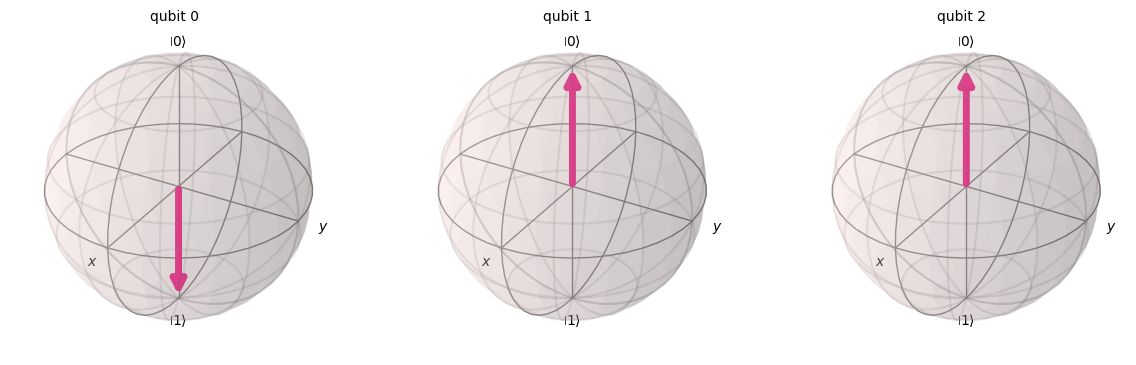

In [ ]:
# inputs
a = 1  # input bit a
b = 0  # input bit b

# Create a quantum circuit
q = QuantumRegister(3)
c = ClassicalRegister(3)
qc = QuantumCircuit(q, c)

# GHZ state preparation  |GHZ⟩ = (|001⟩ + |110⟩) / sqrt(2)
qc.barrier()
qc.h(q[0])
qc.cx(q[0],q[1])
qc.cx(q[1],q[2])
qc.z(q[2])
qc.x(q[2])

# Measure the first qubit in the σx basis if a = 0, or in the σy basis if a = 1
if a == 0:
    qc.h(q[0])
else:
    qc.sdg(q[0])
    qc.h(q[0])

# Measure the second qubit in the σx basis if b = 0, or in the σy basis if b = 1
if b == 0:
    qc.h(q[1])
else:
    qc.sdg(q[1])
    qc.h(q[1])

# # Measure the third qubit in the σx basis if c = 0, or in the σy basis if c = 1
if (a ^ b) == 0:
    qc.h(q[2])

else:
    qc.sdg(q[2])
    qc.h(q[2])

# Perform measurement
qc.barrier(q)
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])
qc.measure(q[2], c[2])

#visualization
backend = Aer.get_backend('aer_simulator')
job = execute(qc, backend, shots=1000)
result = job.result().get_counts()
print(result)

# Extract the XOR result from classical register
c_values = [int(bit) for bit in list(result.keys())[0]]
print("NAND = ", c_values[0] ^ c_values[1] ^ c_values[2])

#ploting bloch sphere for all qubits
qc.save_statevector()
state = backend.run(qc).result().get_statevector()
plot_bloch_multivector(state)



#qc.draw()


Implementation of the the PairwiseAND protocol proposed in [Classical multiparty computation using quantum resources ](https://arxiv.org/abs/1708.06144)

{'0': 1000}


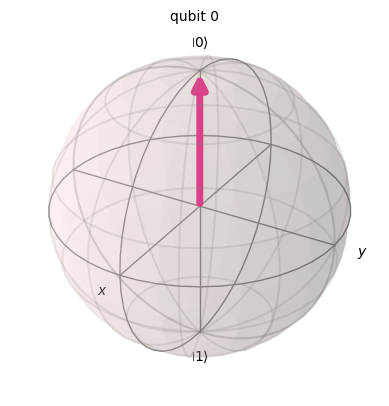

In [ ]:
# Create a quantum circuit
q = QuantumRegister(1)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

# inputs
a = 1  # input bit a
b = 0  # input bit b

# Rotate the qubit based on input a
if a == 1:
    qc.ry(pi/2, q[0])

# Rotate the qubit based on input b
if b == 1:
    qc.ry(pi/2, q[0])

# Rotate the qubit based on input XOR(a,b)
if a ^ b == 1:
    qc.ry(-pi/2, q[0])

# Measure the qubit in computational basis
qc.measure(q[0], c[0])

#visualization
backend = Aer.get_backend('aer_simulator')
job = execute(qc, backend, shots=1000)
result = job.result().get_counts()
print(result)


#ploting bloch sphere for all qubits
qc.save_statevector()
state = backend.run(qc).result().get_statevector()
plot_bloch_multivector(state)


In [ ]:
!cat /etc/*release

DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=20.04
DISTRIB_CODENAME=focal
DISTRIB_DESCRIPTION="Ubuntu 20.04.6 LTS"
NAME="Ubuntu"
VERSION="20.04.6 LTS (Focal Fossa)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 20.04.6 LTS"
VERSION_ID="20.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=focal
UBUNTU_CODENAME=focal
